In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
%load_ext autoreload
%autoreload 2

## Load the Data and plot the number of ratings per movie and user

number of items: 10000, number of users: 1000
shape of dataset: (10000, 1000)


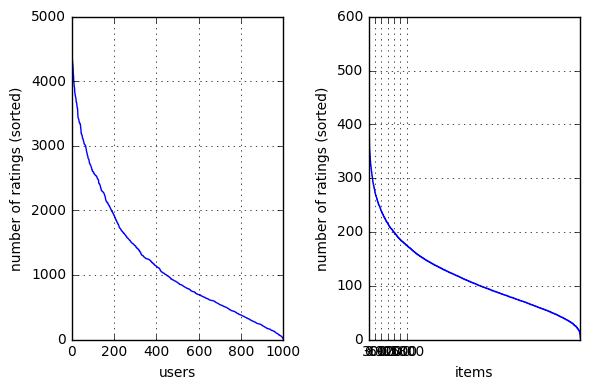

min # of items per user = 8, min # of users per item = 3.


In [2]:
from helpers import load_data, preprocess_data
from plots import plot_raw_data


path_dataset = "../data/data_train.csv"
subset = [100, 101]
#ratings = load_data(path_dataset, subset)
ratings, data = load_data(path_dataset)
print("shape of dataset:",ratings.shape)
#print(ratings)
#print( ratings[0,9])
#print( ratings[0:5,0:5])
#ratings

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

## Run to estimate model

[autoreload of plots failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/home/manana/Machine_Learning_Recommender_Systems/src/plots.py", line 75
    
    ^
SyntaxError: unexpected EOF while parsing
]


splitting data
Percentage of nz train data:  0.8998, percentage of nz test data:  0.1002
generating item and user feature matrices
iter: 0, RMSE on training set: 1.9115616543069462.
iter: 0, RMSE on test set: 2.091750565057215.
iter: 1, RMSE on training set: 0.9075503445706536.
iter: 1, RMSE on test set: 1.4378892121765305.
iter: 2, RMSE on training set: 0.6066410844679037.
iter: 2, RMSE on test set: 1.3535310884088354.
iter: 3, RMSE on training set: 0.4903986605787287.
iter: 3, RMSE on test set: 1.2691156778535482.
iter: 4, RMSE on training set: 0.4339290256469746.
iter: 4, RMSE on test set: 1.2078307861088209.
iter: 5, RMSE on training set: 0.40181750410418815.
iter: 5, RMSE on test set: 1.1656331086971545.
iter: 6, RMSE on training set: 0.38144635295449.
iter: 6, RMSE on test set: 1.135892015685141.
iter: 7, RMSE on training set: 0.3675266266860978.
iter: 7, RMSE on test set: 1.114255538077308.
iter: 8, RMSE on training set: 0.35750877935731773.
iter: 8, RMSE on test set: 1.09806884

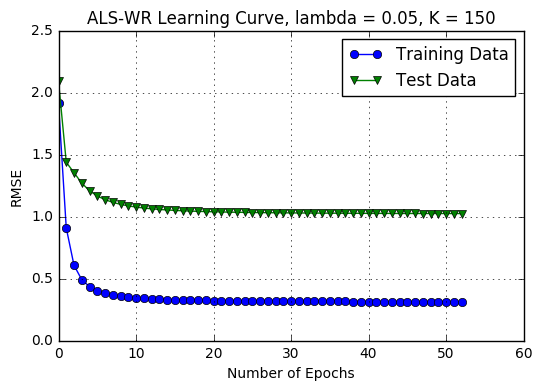

1.01567306874


In [43]:
import our_helpers as ohe
import plots as pl

#defining parameters

lambda_ = 0.05
K = 150
stop_criterion = 1e-4


print("splitting data")
valid_ratings, train, test = ohe.split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)
np.random.seed(600)

print("generating item and user feature matrices")
item_features, user_features, train_errors, test_errors = ohe.ALS(
    train, test,K, lambda_, stop_criterion,  rng)

#creating plot
lambda_str = ('%f' % lambda_).rstrip('0')
path = "%s_%d_%d.jpg"%(lambda_str, K, len(train_errors))
pl.plot_train_test_errors(train_errors, test_errors, lambda_str , K , path, len(train_errors))

#
full_ratings = np.dot( item_features.transpose(), user_features)
nz_rows, nz_cols = test.nonzero()
nz_test = list( zip(nz_rows, nz_cols))

full_ratings_b = ohe.bias_correction(full_ratings, ratings)
print(compute_error2(test, full_ratings_b, nz_test) )


2
2
8
8


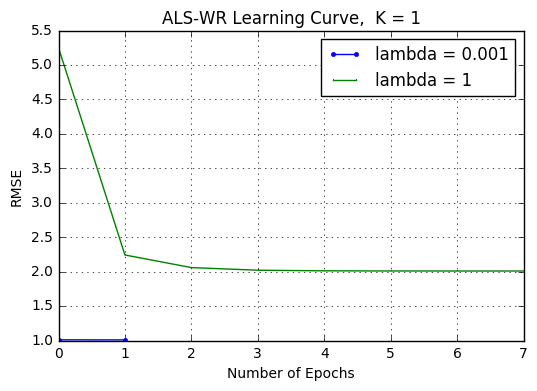

In [21]:
print(len(errors))
print(len(errors[0]))
print(len(errors[1]))
print(len(max(errors, key=len)))
path = "K%d/test_cv_rmse_l%d_nsp%d.jpg"%(num_features, len(lambdas),n_splits )
pl.plot_cv_errors(errors, lambdas, num_features, path)

number of different lambdas :  3
1 / 3
lambda  =  0.0001
iter: 0, RMSE on training set: 0.01982251889665203.
iter: 0, RMSE on test set: 4.221906828540927.
iter: 1, RMSE on training set: 0.010248690953585327.
iter: 1, RMSE on test set: 3.3032279071385573.
iter: 2, RMSE on training set: 0.006606356532539318.
iter: 2, RMSE on test set: 3.028867542155976.
iter: 3, RMSE on training set: 0.004719207527488262.
iter: 3, RMSE on test set: 2.8708033813008065.
iter: 4, RMSE on training set: 0.0035893592534896415.
iter: 4, RMSE on test set: 2.7660396710088584.
iter: 5, RMSE on training set: 0.002847921553133279.
iter: 5, RMSE on test set: 2.685478442221744.
iter: 6, RMSE on training set: 0.002330004257972209.
iter: 6, RMSE on test set: 2.6239282570962854.
iter: 7, RMSE on training set: 0.0019512148023422772.
iter: 7, RMSE on test set: 2.574020975268038.
iter: 8, RMSE on training set: 0.0016642051098350577.
iter: 8, RMSE on test set: 2.5328998688354543.
iter: 9, RMSE on training set: 0.001440567485

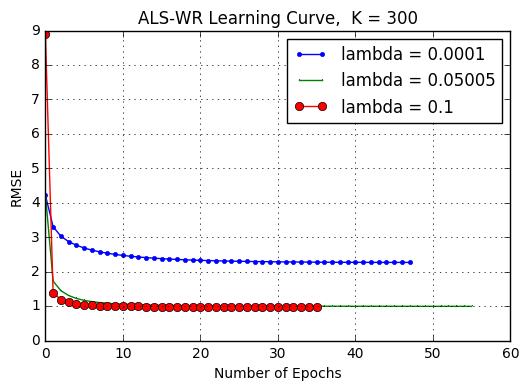

smallest avg error:  0.0973514761949


UnboundLocalError: local variable 'stest' referenced before assignment

In [27]:
import our_helpers as ohe
import plots as pl

#ohe.main(ratings)



"""Alternating Least Squares (ALS) algorithm."""
# define parameters
num_features = 300   # K in the lecture notes
lambda_user = 0.3
lambda_item = 0.3
stop_criterion = 1e-4
n_splits = 10

    
#initialization
sratings = sp.lil_matrix(ratings)
train_errors = []
test_errors = []
    
lambdas = np.linspace( 0.0001, 0.1, 3)

    
print("number of different lambdas : ",len(lambdas))
    
# set seed
np.random.seed(988)
    
    
test_avg_cost, train_avg_cost , errors = ohe.cross_validation(
sratings, n_splits, num_features, lambdas, stop_criterion)
    
#generating plot
path = "/K%d/l%d_nsp%d.jpg"%(num_features, len(lambdas),n_splits )
    
pl.plot_cv_errors(errors, lambdas, num_features, path)
    
ind = np.argmin(test_avg_cost)
print("smallest avg error: ",test_avg_cost[ind])
    
lambda_ = lambdas[ind]
    
    
vl, train, test = ohe.split_data(ratings, num_items_per_user, num_users_per_item,0)
    
item_features , user_features , rmse_tr, rmse_te = ALS (
train , test, num_features,lambda_[0], 
lambda_[1], stop_criterion,error_list, 250 )
    
ratings_full = np.dot(np.transpose(item_features),user_features)

# Create Sumbmissions

In [15]:
from our_helpers import create_submission
path_output = "submission.csv"

#create_submission(path_output, full_ratings_b)

create_submission(path_output, X_filled_nnm_2 )

number of items: 10000, number of users: 1000


# test ALT

In [13]:
print(X_filled_nnm_2.shape)
error = ohe.compute_error2(test, X_filled_nnm_2, nz_test)
print(error)

(10000, 1000)
1.03818504741


In [6]:
#scored 1.05
import fancyimpute as fi
import our_helpers as ohe

valid_ratings, train, test,stest = ohe.split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1,sparse= False)

print(data.shape)
nz_rows, nz_cols = stest.nonzero()
nz_test = list( zip(nz_rows, nz_cols))
train[train == 0 ] = 'nan'
X_filled_nnm_1 = fi.SoftImpute().complete(train)
error = ohe.compute_error2(test, X_filled_nnm_1, nz_test)
print(error)

(10000, 1000)
[SoftImpute] Max Singular Value of X_init = 141.828063
[SoftImpute] Iter 1: observed MAE=0.064029 rank=999
[SoftImpute] Iter 2: observed MAE=0.064057 rank=999
[SoftImpute] Iter 3: observed MAE=0.064076 rank=998
[SoftImpute] Iter 4: observed MAE=0.064087 rank=995
[SoftImpute] Iter 5: observed MAE=0.064087 rank=991
[SoftImpute] Iter 6: observed MAE=0.064082 rank=988
[SoftImpute] Iter 7: observed MAE=0.064070 rank=984
[SoftImpute] Iter 8: observed MAE=0.064049 rank=978
[SoftImpute] Iter 9: observed MAE=0.064015 rank=970
[SoftImpute] Iter 10: observed MAE=0.063974 rank=964
[SoftImpute] Iter 11: observed MAE=0.063930 rank=957
[SoftImpute] Iter 12: observed MAE=0.063880 rank=949
[SoftImpute] Iter 13: observed MAE=0.063818 rank=939
[SoftImpute] Iter 14: observed MAE=0.063751 rank=932
[SoftImpute] Iter 15: observed MAE=0.063686 rank=924
[SoftImpute] Iter 16: observed MAE=0.063619 rank=916
[SoftImpute] Iter 17: observed MAE=0.063544 rank=906
[SoftImpute] Iter 18: observed MAE=0.06

In [11]:
import fancyimpute as fi
import our_helpers as ohe

X_filled_nnm_2 = fi.NuclearNormMinimization().complete(train)
error = ohe.compute_error2(test, X_filled_nnm, nz_test)
print(error)

KeyboardInterrupt: 

In [20]:
import fancyimpute as fi
import our_helpers as ohe

X_filled_nnm_2 = fi.MatrixFactorization(rank=2,l1_penalty=0.065, l2_penalty=0.065).complete(train)
error = ohe.compute_error2(test, X_filled_nnm_2, nz_test)
print(error)

I 2016-12-18 00:09:08 downhill.dataset:174 train: 1 of 1 mini-batches from (10000, 1000)
I 2016-12-18 00:09:08 downhill.base:389 -- patience = 5
I 2016-12-18 00:09:08 downhill.base:390 -- validate_every = 10
I 2016-12-18 00:09:08 downhill.base:391 -- max_updates = None
I 2016-12-18 00:09:08 downhill.base:392 -- min_improvement = 0.005
I 2016-12-18 00:09:08 downhill.base:393 -- max_gradient_norm = 10
I 2016-12-18 00:09:08 downhill.base:394 -- max_gradient_elem = 0
I 2016-12-18 00:09:08 downhill.base:395 -- learning_rate = 0.001
I 2016-12-18 00:09:08 downhill.base:396 -- momentum = 0
I 2016-12-18 00:09:08 downhill.base:397 -- nesterov = False
I 2016-12-18 00:09:08 downhill.adaptive:220 -- rms_halflife = 14
I 2016-12-18 00:09:08 downhill.adaptive:221 -- rms_regularizer = 1e-08
I 2016-12-18 00:09:08 downhill.base:118 compiling evaluation function
I 2016-12-18 00:09:09 downhill.base:124 compiling Adam function
I 2016-12-18 00:09:11 downhill.base:232 validation 0 loss=0.429184 error=0.314141

In [ ]:
#1.03 achvenebda fancyiomputis matrix factorization metodi, kaggleze = 1.05776